## Import Packages

In [56]:
# Analyzing, cleaning, exploring data
import pandas as pd
from pandas import DataFrame
import re
import glob

# Performing math operations on arrays and other structures.
import numpy as np

# Visualizing data
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

import pywt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder


from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix



## Import and Process Data

In the cell below we import 700 files, assign columns, extract names and numbers from the file names and build a combined dataframe.

In [33]:
# Initialize Lists
truncated_data = []
new_list2 = []
dataframes = []
total_num_rows = 0
extracted_strings = []
gesture_list = []

# Specify the folder path where the CSV files are located
folder_path = "/content/drive/MyDrive/EMGforMSc_copy/"

# Column Names
columns = ['Timestamp', 'El1', 'El2', 'El3','El4', 'El5', 'El6','El7', 'El8']


# Get a list of all CSV files in the folder
file_list = glob.glob(folder_path + "*.csv")

for file in file_list:
    df = pd.read_csv(file, names=columns)

    # Truncate the DataFrames to 100 rows
    truncated_df = df[:100]

    # Add the truncated DataFrame to the list
    truncated_data.append(truncated_df)
    #num_rows = 200

    file_name = file.split("/")[-1]  # Extract the file name from the file path
    gesture = re.search(r'-(.*?)-', file_name).group(1)  # Extract the desired string using regex

    # Get a list for the target variable
    gesture_list.extend([gesture])

    # Get a list in case we need to add a column to the df
    extracted_strings.extend([gesture] * num_rows)

    # Get the Patient ID
    extracted_numbers = re.findall(r'\d+', file)[0]


    #new_list = [extracted_numbers] * num_rows
    #new_list2.append(new_list)
    #dataframes.append(df)

    #total_num_rows += num_rows
    #filtered_dataframes = [truncated_data for truncated_data in dataframes if len(truncated_data) <= 200]




combined_df = pd.concat(truncated_data, ignore_index=False) # The final df with all the data
#new_list2 = [item for sublist in new_list2 for item in sublist]  # Flatten the nested list


In [34]:
combined_df

,Timestamp,El1,El2,El3,El4,El5,El6,El7,El8
0,1647185099821,26,22,23,22,33,40,227,118
1,1647185099950,24,20,23,22,34,41,231,121
2,1647185100080,24,20,21,23,34,35,177,92
3,1647185100241,25,21,21,22,35,37,177,91
4,1647185100390,30,25,23,20,28,39,191,100
...,...,...,...,...,...,...,...,...,...
95,1648812705182,22,30,61,135,140,99,35,26
96,1648812705188,24,31,63,137,149,104,37,28
97,1648812705194,25,28,61,156,153,100,38,28
98,1648812705200,27,35,59,155,150,94,36,28


## Encode the Target Variable

Seems to be necessary for a CNN. Encoded all gestures below.

In [35]:
# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Encode the target variable as integer labels
integer_labels = label_encoder.fit_transform(gesture_list)

# Create an instance of OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)

# Reshape the integer labels to a 2D array
integer_labels = integer_labels.reshape(-1, 1)

# One-hot encode the integer labels
onehot_encoded = onehot_encoder.fit_transform(integer_labels)

onehot_encoded

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]])

In [36]:
# Convert to Array
gesture_list = np.array(onehot_encoded)


In [37]:
# Copy dataframe for good measure
df = combined_df.copy()

## Apply Continuous Wavelet Transform

In [38]:
# Define parameters
scales = np.arange(1, 101)
waveletname = "morl"
num_rows = 100
num_columns = 8


# Extract the electrode readings columns
data = df.iloc[:, 1:].values  # Exclude the timestamp column

# Reshape the data into 3D array (number of samples, number of rows, number of columns)
data = data.reshape(-1, num_rows, num_columns)

# Apply continuous wavelet transform to each sample
transformed_data = []

for sample in data:
    transformed_sample = []
    for channel in sample.T:  # Transpose to loop over columns (channels)
        coeff, _ = pywt.cwt(channel, scales, waveletname, 1)
        transformed_sample.append(coeff)
    transformed_data.append(np.array(transformed_sample))

# Convert the transformed data into a numpy array
transformed_data = np.array(transformed_data)

In [39]:
# Reshape data to the format below
reshaped_data = transformed_data.transpose((0, 3, 2, 1))


In [40]:
# 700 files/signals
# 100 rows from each file
# 100 cofficients of each row
# 8 channels representing the electrode readhings

reshaped_data.shape

(700, 100, 100, 8)

## Split Data

In [41]:
X_train, X_test, y_train, y_test = train_test_split(reshaped_data, gesture_list, test_size=0.2, random_state=42)


## A Rudimentary CNN

In [42]:
# Build the CNN model
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(100, 100, 8)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



In [58]:
# Summarize Model
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 98, 98, 16)        1168      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 49, 49, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 16928)             0         
                                                                 
 dense_4 (Dense)             (None, 64)               

In [45]:
# Fit the Model
model.fit(X_train, y_train, epochs=15, batch_size=32)

Epoch 1/15
18/18 [==============================] - 5s 265ms/step - loss: 0.0261 - accuracy: 0.9875
Epoch 2/15
18/18 [==============================] - 7s 406ms/step - loss: 0.0230 - accuracy: 0.9893
Epoch 3/15
18/18 [==============================] - 5s 304ms/step - loss: 0.0224 - accuracy: 0.9875
Epoch 4/15
18/18 [==============================] - 7s 363ms/step - loss: 0.0241 - accuracy: 0.9893
Epoch 5/15
18/18 [==============================] - 7s 374ms/step - loss: 0.0260 - accuracy: 0.9893
Epoch 6/15
18/18 [==============================] - 5s 254ms/step - loss: 0.0187 - accuracy: 0.9929
Epoch 7/15
18/18 [==============================] - 7s 379ms/step - loss: 0.0172 - accuracy: 0.9946
Epoch 8/15
18/18 [==============================] - 5s 257ms/step - loss: 0.0152 - accuracy: 0.9964
Epoch 9/15
18/18 [==============================] - 5s 260ms/step - loss: 0.0139 - accuracy: 0.9964
Epoch 10/15
18/18 [==============================] - 7s 371ms/step - loss: 0.0145 - accuracy: 0.9964

In [46]:
# Evaluate the model on the validation dataset
val_loss, val_accuracy = model.evaluate(X_test, y_test)

# Print the validation loss and accuracy
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

5/5 [==============================] - 1s 68ms/step - loss: 0.7705 - accuracy: 0.7286
Validation Loss: 0.7705090045928955
Validation Accuracy: 0.7285714149475098


In [57]:
# Calculate accuracy
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred_labels)
accuracy

0.7285714285714285

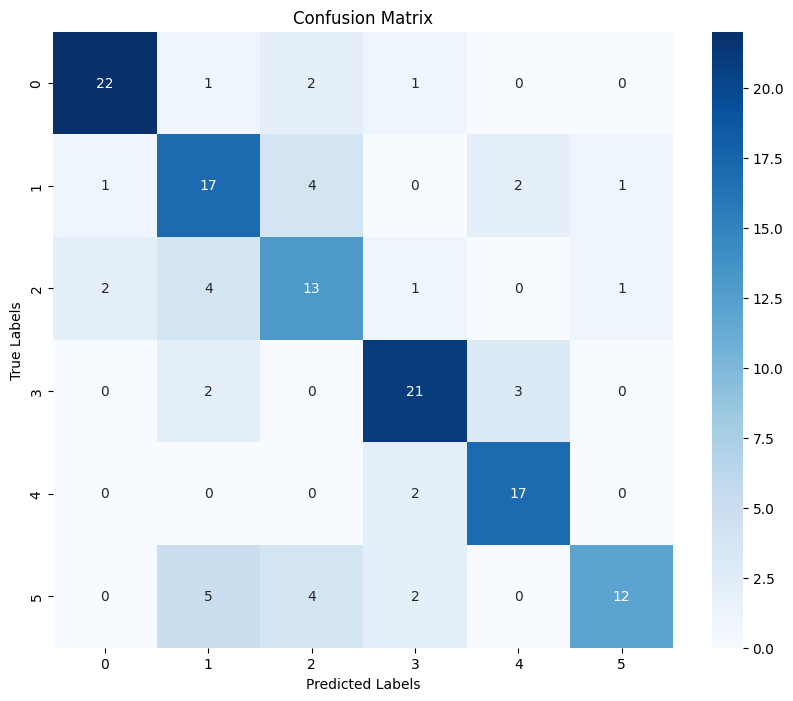

In [52]:
y_pred_probs = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Compute confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()